In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

In [3]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']
play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [4]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)
#tracking_df['pos_delta'] = tracking_df.apply(lambda x: get_position_delta(x), axis=1)

In [6]:
# Attempt clustering of play data

In [7]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [8]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(df_scaled)

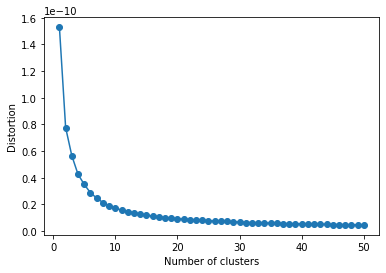

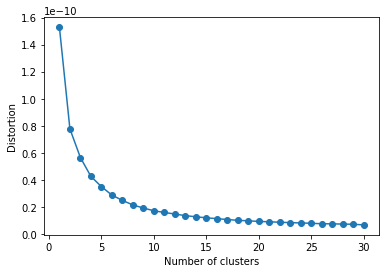

In [22]:
distortions = []
num_plays = 30

for i in range(1, num_plays + 1):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(df_scaled.drop(['gameId', 'playId'], axis=1))
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [30]:
limit = 0.000001
model = AgglomerativeClustering(linkage='ward',
                                distance_threshold=limit,
                                n_clusters=None)
model.fit(df_scaled.drop(['gameId', 'playId'], axis=1))
df['cluster'] = model.labels_

In [31]:
len(np.unique(model.labels_))

19

In [32]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

cluster
0     2041
1      974
2     1444
3     1533
4      573
5     1137
6      189
7      257
8      361
9      548
10      20
11     565
12    1111
13     551
14     310
15     640
16       7
17      20
18     104
dtype: int64

In [33]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for idx, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[idx] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

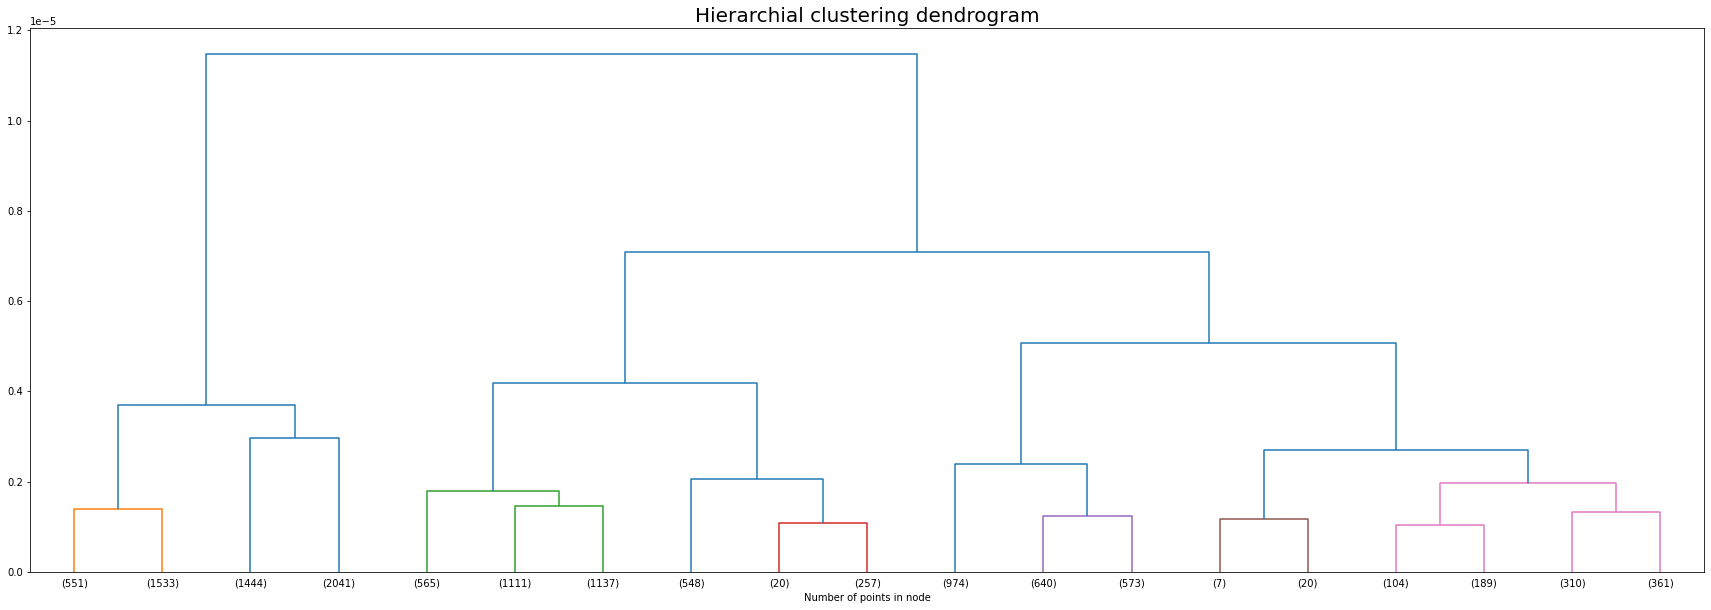

In [34]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.set_title('Hierarchial clustering dendrogram', fontsize=20)
#plot_dendrogram(model)
plot_dendrogram(model, truncate_mode='lastp', p=len(np.unique(model.labels_)), show_leaf_counts=True, color_threshold=limit*2)
# plt.axhline(y=1000, color='r', linestyle='--')
# plt.axhline(y=200, color='r', linestyle='--')
# plt.axhline(y=100, color='r', linestyle='--')
plt.xticks(fontsize=10, rotation=0)
ax.set_xlabel('Number of points in node', fontsize=10)
plt.show()

In [39]:
play_df.loc[df.loc[df['cluster'] == 17].index.values[0]]['playId']

1651.0

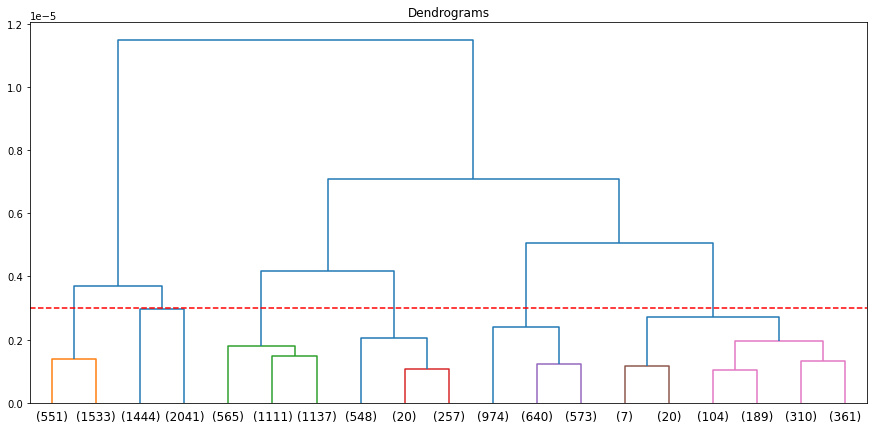

In [46]:
plt.figure(figsize=(15, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'), truncate_mode='lastp', p=len(np.unique(model.labels_)), show_leaf_counts=True, color_threshold=limit*2)
plt.axhline(y=0.000003, color='r', linestyle='--')
plt.axhline(y=0.00003, color='g', linestyle='--')
plt.axhline(y=0.0003, color='r', linestyle='--')

In [47]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_scaled.drop(['gameId', 'playId'], axis=1))

array([19, 12, 19, ..., 13, 19,  3])

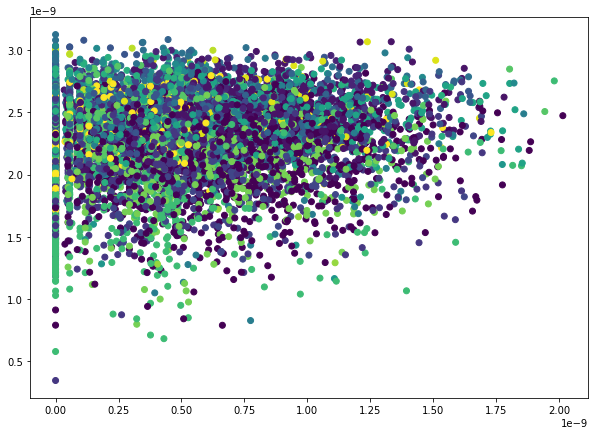

In [48]:
plt.figure(figsize=(10,7))
plt.scatter(df_scaled['offense_h_presnap'], df_scaled['offense_h_to_throw'], c=cluster.labels_)

In [ ]:
stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
pairs = []
for subset in combinations(stuff, 2):
    pairs.append(subset)
fig_cols = 3
fig_rows = int(np.ceil(len(pairs) / fig_cols))

plt.figure()
for i in range(1, fig_cols + 1):
    for j in range(1, fig_rows + 1):
        plt.subplot(i, j, 1)
        plt.scatter(df[pairs[0][0]], df[pairs[0][1]], c=cluster.labels_)


In [ ]:
stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(stuff, 2):
    plt.figure(figsize=(10,7))
    plt.scatter(df[subset[0]], df[subset[1]], c=cluster.labels_)
    plt.xlabel(subset[0])
    plt.ylabel(subset[1])

In [ ]:
df.drop(['gameId', 'playId'], axis=1).head()

In [ ]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

x = df_scaled['offense_h_to_throw']
y = df_scaled['offense_a_to_throw']
main_ax.scatter(x, y, c=cluster.labels_)

x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
y_hist.invert_xaxis()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

In [ ]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [ ]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [ ]:
ids = motion_ids['g-pid'].unique()

In [ ]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [ ]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [ ]:
play_df

In [ ]:
play_presnap

In [ ]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [ ]:
play_nomotion

In [ ]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

In [ ]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [ ]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [ ]:
ids = motion_ids['g-pid'].unique()

In [ ]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [ ]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [ ]:
play_df

In [ ]:
play_presnap

In [ ]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [ ]:
play_nomotion

In [ ]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

In [ ]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

In [ ]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']
play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [ ]:
frame_df.head()

In [ ]:
tracking_df.head()

In [ ]:
play_df[['offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap', 'offense_h_presnap']].plot.box()
play_df[['defense_p_presnap', 'defense_m_presnap', 'defense_v_presnap', 'defense_h_presnap']].plot.box()

In [ ]:
play_df[['offense_p_to_throw', 'offense_m_to_throw', 'offense_v_to_throw', 'offense_a_to_throw', 'offense_h_to_throw']].plot.box()
play_df[['defense_p_to_throw', 'defense_m_to_throw', 'defense_v_to_throw', 'defense_a_to_throw', 'defense_h_to_throw']].plot.box()

In [ ]:
play_df[['offense_a_presnap', 'defense_a_presnap']].plot.box()

In [ ]:
plt.boxplot(play_df[['offense_a_presnap']])
plt.boxplot(play_df[['defense_a_presnap']])

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def string_to_vector(s):
    s = s.split('[')[1].split(']')[0]
    x = float(s.split()[0])
    y = float(s.split()[1])
    return np.array([x, y])

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [ ]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)
# tracking_df['pos_delta'] = tracking_df.apply(lambda x: get_position_delta(x), axis=1)

In [ ]:
# Attempt clustering of play data

In [ ]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(play_df.dropna())

In [ ]:
distortions = []
num_plays = play_df.dropna().shape[0]
num_plays = 15
for i in range(1, num_plays):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(play_df.dropna())
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
play_df.columns

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

In [ ]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
model = AgglomerativeClustering(linkage='ward',
                                distance_threshold=7,
                                n_clusters=None)
model.fit(df.drop(['gameId', 'playId'], axis=1))
df['cluster'] = model.labels_

In [ ]:
df['cluster'].max()

In [ ]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for idx, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[idx] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.set_title('Hierarchial clustering dendrogram', fontsize=20)
plot_dendrogram(model)
# plot_dendrogram(model, truncate_mode='level', p=5)
# plt.axhline(y=1000, color='r', linestyle='--')
# plt.axhline(y=200, color='r', linestyle='--')
# plt.axhline(y=100, color='r', linestyle='--')
plt.xticks(fontsize=10, rotation=0)
ax.set_xlabel('Number of points in node', fontsize=10)
plt.show()

In [ ]:
play_df.loc[df.loc[df['cluster'] == 48].index.values[0]]['playId']

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))
plt.axhline(y=0.0000005, color='r', linestyle='--')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_scaled.drop(['gameId', 'playId'], axis=1))

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_scaled['offense_h_presnap'], df_scaled['offense_h_to_throw'], c=cluster.labels_)

In [ ]:
from itertools import combinations

stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
pairs = []
for subset in combinations(stuff, 2):
    pairs.append(subset)
fig_cols = 3
fig_rows = int(np.ceil(len(pairs) / fig_cols))

plt.figure()
for i in range(1, fig_cols + 1):
    for j in range(1, fig_rows + 1):
        plt.subplot(i, j, 1)
        plt.scatter(df[pairs[0][0]], df[pairs[0][1]], c=cluster.labels_)


In [ ]:
stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(stuff, 2):
    plt.figure(figsize=(10,7))
    plt.scatter(df[subset[0]], df[subset[1]], c=cluster.labels_)
    plt.xlabel(subset[0])
    plt.ylabel(subset[1])

In [ ]:
df.drop(['gameId', 'playId'], axis=1).head()

In [ ]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

x = df_scaled['offense_h_to_throw']
y = df_scaled['offense_a_to_throw']
main_ax.scatter(x, y, c=cluster.labels_)

x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
y_hist.invert_xaxis()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

In [ ]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [ ]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [ ]:
ids = motion_ids['g-pid'].unique()

In [ ]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [ ]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [ ]:
play_df

In [ ]:
play_presnap

In [ ]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [ ]:
play_nomotion

In [ ]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

In [ ]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [ ]:
play_nomotion

In [ ]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

In [ ]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [ ]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [ ]:
ids = motion_ids['g-pid'].unique()

In [ ]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [ ]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [ ]:
play_df

In [ ]:
play_presnap

In [ ]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [ ]:
play_nomotion

In [ ]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

In [3]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']
play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [92]:
frame_df.head()

,gameId,playId,frameId,offense_p_group,defense_p_group,offense_m_group,defense_m_group,o_state,d_state,offense_v_group,defense_v_group,offense_a_group,defense_a_group,a_group_ratio
0,2018090600,75,1.0,0.538470,0.413698,0.405248,0.372372,transitional,transitional,0.000000,0.000000,83.68815,194.31095,0.430692
1,2018090600,75,2.0,0.529709,0.525295,0.388188,0.350750,transitional,transitional,0.019003,0.022588,83.73575,194.31055,0.430938
2,2018090600,75,3.0,0.539574,0.535192,0.396913,0.341001,transitional,transitional,0.007454,0.004518,83.78335,194.35200,0.431091
3,2018090600,75,4.0,0.540062,0.526223,0.430916,0.374983,transitional,transitional,0.007454,0.012778,83.78375,194.57140,0.430607
4,2018090600,75,5.0,0.509301,0.499902,0.501201,0.384229,transitional,transitional,0.011785,0.020203,83.79405,194.88905,0.429958


In [93]:
tracking_df.head()

,time,s,a,dis,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,pos,teamType,o_vec,dir_vec,r_vec
0,2018-09-07 01:07:14.599000+00:00,0.00,0.01,0.02,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,[28.27 26.63],offense,[ 0.94223297 -0.33495826],[0.87402675 0.48587781],[0.34558745 0.93838655]
1,2018-09-07 01:07:14.599000+00:00,0.02,0.03,0.01,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,[28.65 9.14],offense,[ 0.93697745 -0.34938985],[-0.29003414 -0.9570163 ],[ 0.12496368 -0.99216132]
2,2018-09-07 01:07:14.599000+00:00,0.00,0.00,0.00,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,[29.22 17.15],offense,[0.97670974 0.21456486],[0.24141382 0.97042226],[ 0.37023815 -0.92893687]
3,2018-09-07 01:07:14.599000+00:00,0.01,0.01,0.00,None,2543583.0,Devonta Freeman,24.0,RB,1,away,2018090600,75,left,NaN,[21.75 26.67],offense,[0.99741576 0.07184561],[0.25054897 0.96810393],[-0.81064472 0.58553834]
4,2018-09-07 01:07:14.599000+00:00,0.01,0.02,0.01,None,2555415.0,Austin Hooper,81.0,TE,1,away,2018090600,75,left,OUT,[28.71 31.47],offense,[0.94170565 0.33643791],[-0.47208925 0.88155076],[0.2063285 0.97848278]


<AxesSubplot:>

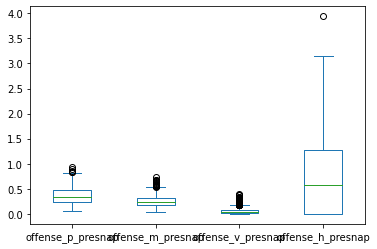

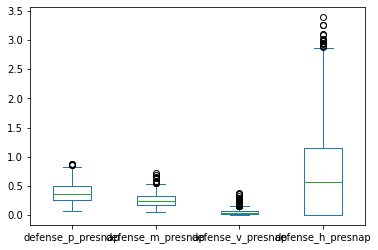

In [94]:
play_df[['offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap', 'offense_h_presnap']].plot.box()
play_df[['defense_p_presnap', 'defense_m_presnap', 'defense_v_presnap', 'defense_h_presnap']].plot.box()

<AxesSubplot:>

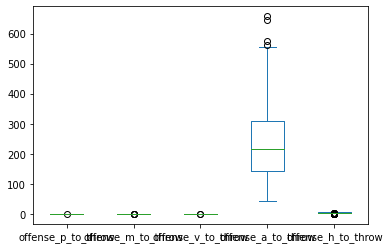

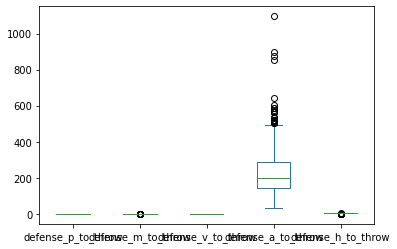

In [95]:
play_df[['offense_p_to_throw', 'offense_m_to_throw', 'offense_v_to_throw', 'offense_a_to_throw', 'offense_h_to_throw']].plot.box()
play_df[['defense_p_to_throw', 'defense_m_to_throw', 'defense_v_to_throw', 'defense_a_to_throw', 'defense_h_to_throw']].plot.box()

<AxesSubplot:>

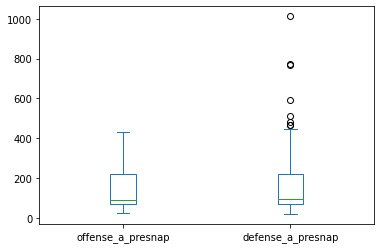

In [96]:
play_df[['offense_a_presnap', 'defense_a_presnap']].plot.box()

{'whiskers': [<matplotlib.lines.Line2D at 0x2ad477460>,
 'caps': [<matplotlib.lines.Line2D at 0x2ad477a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ad477190>],
 'medians': [<matplotlib.lines.Line2D at 0x2ad477fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ad4822b0>],
 'means': []}

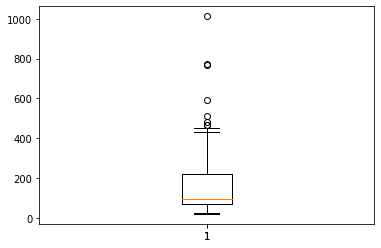

In [97]:
plt.boxplot(play_df[['offense_a_presnap']])
plt.boxplot(play_df[['defense_a_presnap']])

In [4]:
from sklearn.cluster import KMeans

In [5]:
def string_to_vector(s):
    s = s.split('[')[1].split(']')[0]
    x = float(s.split()[0])
    y = float(s.split()[1])
    return np.array([x, y])

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [6]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)
# tracking_df['pos_delta'] = tracking_df.apply(lambda x: get_position_delta(x), axis=1)

In [101]:
# Attempt clustering of play data

In [8]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(play_df.dropna())

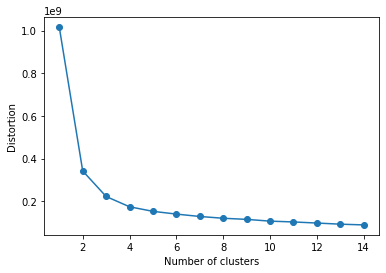

In [9]:
distortions = []
num_plays = play_df.dropna().shape[0]
num_plays = 15
for i in range(1, num_plays):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(play_df.dropna())
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [10]:
play_df.columns

Index(['gameId', 'playId', 'offense_h_play', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end',
       'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw',
       'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_p_to_end', 'offense_m_play', 'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end',
       'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'offense_a_to_end', 'defense_p_play', 'defense_p_presnap',
       'defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end',
       'defense_m_play', 'defense_m_presnap', 'defense_m_to_throw',
       'defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play',
       'defense_v_presna

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

In [12]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
model = AgglomerativeClustering(linkage='ward',
                                distance_threshold=7,
                                n_clusters=None)
model.fit(df.drop(['gameId', 'playId'], axis=1))
df['cluster'] = model.labels_

In [13]:
df['cluster'].max()

657

In [14]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

cluster
0      2
1      2
2      2
3      2
4      2
      ..
653    1
654    1
655    1
656    1
657    1
Length: 658, dtype: int64

In [15]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for idx, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[idx] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

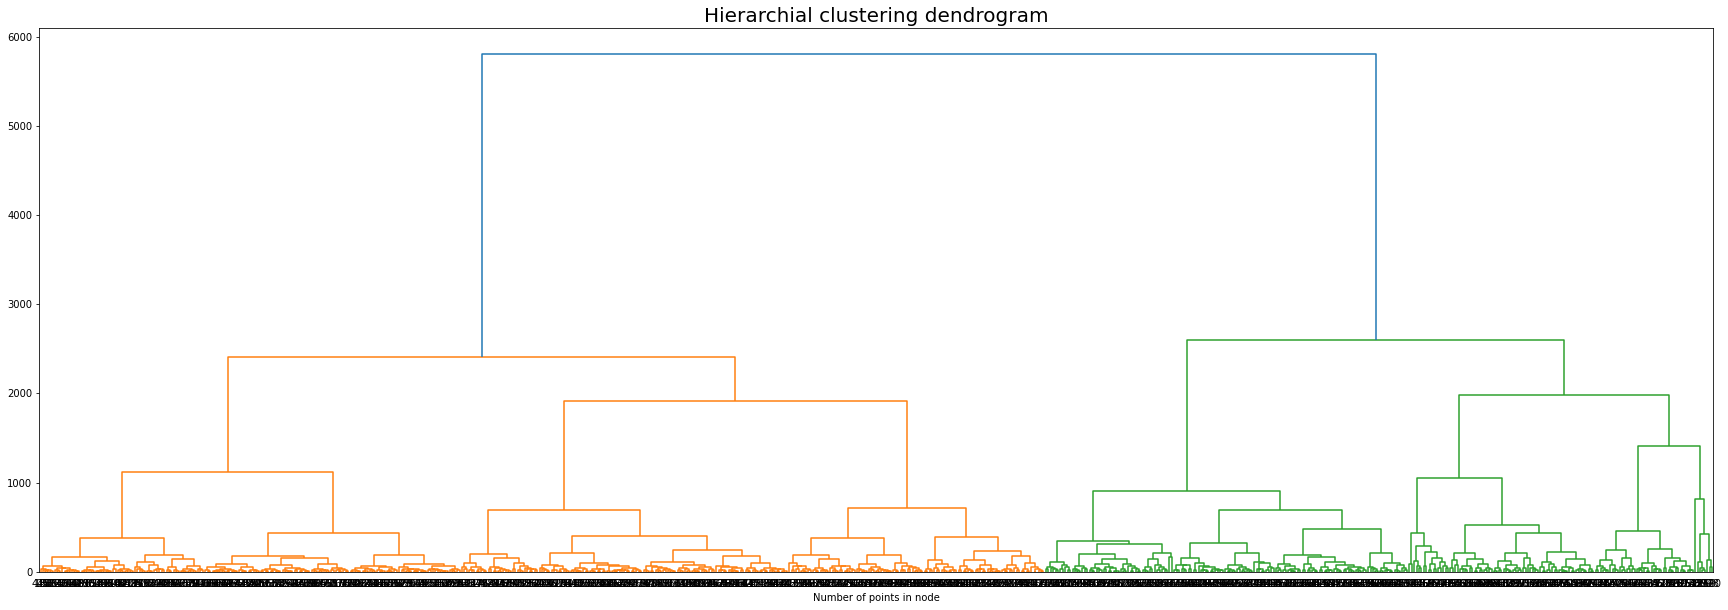

In [110]:
fig, ax = plt.subplots(figsize = (30, 10))
ax.set_title('Hierarchial clustering dendrogram', fontsize=20)
plot_dendrogram(model)
# plot_dendrogram(model, truncate_mode='level', p=5)
# plt.axhline(y=1000, color='r', linestyle='--')
# plt.axhline(y=200, color='r', linestyle='--')
# plt.axhline(y=100, color='r', linestyle='--')
plt.xticks(fontsize=10, rotation=0)
ax.set_xlabel('Number of points in node', fontsize=10)
plt.show()

In [111]:
play_df.loc[df.loc[df['cluster'] == 48].index.values[0]]['playId']

4192.0

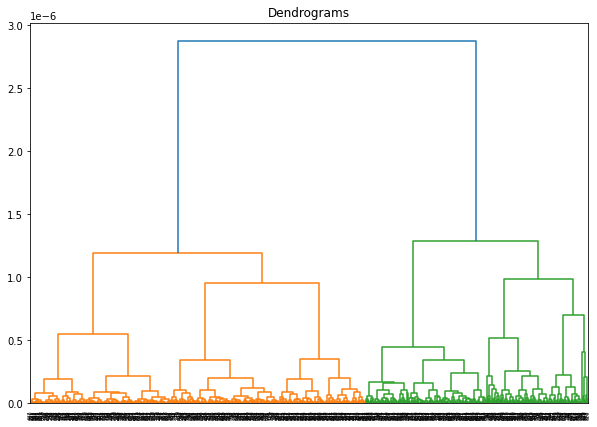

In [16]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))

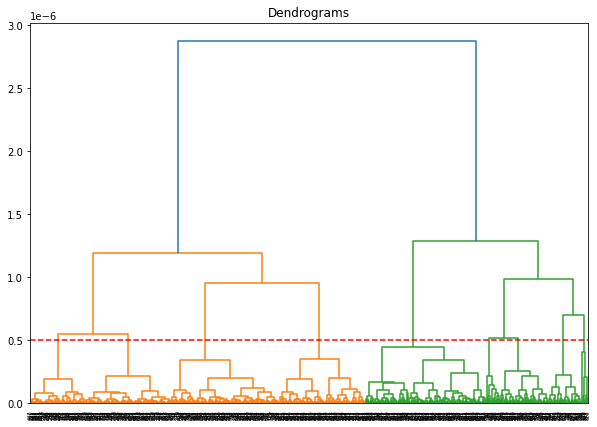

In [113]:
plt.figure(figsize=(10, 7))
plt.title('Dendrograms')
dend = shc.dendrogram(shc.linkage(df_scaled.drop(['gameId', 'playId'], axis=1), method='ward'))
plt.axhline(y=0.0000005, color='r', linestyle='--')

In [17]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_scaled.drop(['gameId', 'playId'], axis=1))

array([3, 3, 3, 3, 3, 1, 3, 0, 3, 0, 0, 0, 3, 1, 0, 0, 3, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0,
       1, 3, 1, 3, 1, 0, 1, 0, 1, 0, 3, 3, 0, 3, 2, 2, 2, 1, 0, 3, 0, 4,
       2, 3, 3, 4, 4, 3, 0, 3, 1, 3, 3, 0, 4, 2, 4, 3, 3, 2, 4, 2, 0, 4,
       3, 4, 4, 0, 3, 4, 4, 4, 2, 3, 3, 4, 0, 3, 0, 3, 3, 0, 0, 0, 3, 0,
       3, 0, 3, 0, 2, 0, 3, 3, 1, 1, 3, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 3, 3, 1, 2,
       0, 0, 2, 2, 0, 0, 1, 1, 3, 4, 2, 0, 0, 2, 2, 0, 2, 2, 3, 0, 3, 0,
       4, 0, 3, 3, 3, 1, 3, 3, 0, 4, 2, 4, 0, 0, 0, 2, 4, 2, 1, 3, 4, 3,
       4, 2, 2, 3, 0, 2, 0, 3, 3, 3, 3, 0, 3, 3, 0, 4, 0, 2, 4, 0, 1, 3,
       3, 0, 0, 0, 0, 0, 3, 3, 3, 1, 0, 2, 2, 0, 0, 0, 2, 3, 3, 0, 0, 0,
       4, 3, 3, 0, 0, 0, 0, 2, 1, 3, 0, 0, 2, 0, 4, 4, 2, 0, 0, 0, 3, 3,
       3, 0, 3, 4, 3, 0, 0, 4, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 1, 0, 2, 2,
       0, 2, 0, 0, 3, 0, 2, 0, 4, 3, 1, 0, 0, 1, 2,

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_scaled['offense_h_presnap'], df_scaled['offense_h_to_throw'], c=cluster.labels_)

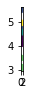

In [38]:
from itertools import combinations

stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
pairs = []
for subset in combinations(stuff, 2):
    pairs.append(subset)
fig_cols = 3
fig_rows = int(np.ceil(len(pairs) / fig_cols))

plt.figure()
for i in range(1, fig_cols + 1):
    for j in range(1, fig_rows + 1):
        plt.subplot(i, j, 1)
        plt.scatter(df[pairs[0][0]], df[pairs[0][1]], c=cluster.labels_)


In [ ]:
stuff = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(stuff, 2):
    plt.figure(figsize=(10,7))
    plt.scatter(df[subset[0]], df[subset[1]], c=cluster.labels_)
    plt.xlabel(subset[0])
    plt.ylabel(subset[1])

In [40]:
df.drop(['gameId', 'playId'], axis=1).head()

,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,offense_m_to_arrived,offense_v_presnap,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,cluster
0,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,0.393187,0.008809,...,0,0,0,0,0,0,0,0,0,0
1,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,0.393187,0.008809,...,0,0,0,0,0,0,0,0,0,0
2,2.066397,4.342403,4.110577,0.416672,0.285869,0.488295,0.296787,0.364306,0.266904,0.113982,...,0,0,0,0,0,0,0,0,0,5
3,0.995729,4.562350,4.479730,0.263209,0.459695,0.763531,0.233605,0.423727,0.225428,0.236334,...,0,2,0,1,0,0,0,0,0,6
4,-0.000000,3.110556,3.981765,0.227316,0.189975,0.300707,0.223542,0.326697,0.194162,0.008402,...,0,0,0,2,0,0,1,0,0,7


(array([578.,   0.,  85.,   0.,   0.,  25.,   0.,   2.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

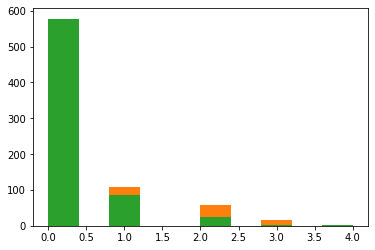

In [116]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

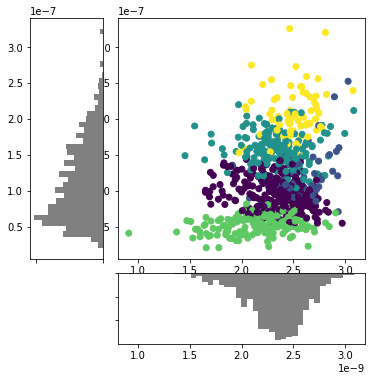

In [117]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

x = df_scaled['offense_h_to_throw']
y = df_scaled['offense_a_to_throw']
main_ax.scatter(x, y, c=cluster.labels_)

x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
y_hist.invert_xaxis()

In [18]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [19]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

<IPython.core.display.Javascript object>

In [20]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [21]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [22]:
ids = motion_ids['g-pid'].unique()

In [23]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [24]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [25]:
play_df

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
0,2018090600,75,5.145521,-0.000000,4.733452,4.306341,4.764014,4.750136,-0.000000,4.008848,...,0,0,0,0,0,0,0,0,0,2018090600-75
1,2018090600,146,4.239564,0.722081,4.249899,3.185872,4.265621,4.872203,1.546312,3.939565,...,1,0,0,0,0,0,0,0,0,2018090600-146
2,2018090600,168,4.433406,-0.000000,4.256503,-0.000000,-0.000000,4.444197,0.820328,4.035433,...,0,1,2,1,0,0,0,0,0,2018090600-168
3,2018090600,190,5.360222,-0.000000,5.278721,4.789590,3.919888,5.203300,2.119310,4.312658,...,0,0,0,0,1,1,0,0,0,2018090600-190
4,2018090600,256,4.182727,0.592412,3.949740,4.065981,3.628376,4.317301,2.181818,3.593447,...,0,2,0,0,0,0,0,0,0,2018090600-256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,2018091001,3952,5.301264,1.804638,5.076396,4.738543,4.507207,5.017195,-0.000000,5.164449,...,0,0,0,0,0,0,0,0,0,2018091001-3952
948,2018091001,3976,5.640611,2.061894,5.100693,4.347991,5.015432,5.329044,-0.000000,5.019239,...,0,0,0,0,0,0,0,0,0,2018091001-3976
949,2018091001,4123,5.936562,1.402238,5.483511,4.434417,6.016275,5.424850,-0.000000,4.948631,...,0,0,0,0,0,0,0,0,0,2018091001-4123
950,2018091001,4147,5.202134,0.752809,4.224517,4.466213,5.342699,4.558570,-0.000000,4.412011,...,0,0,0,0,0,0,0,0,0,2018091001-4147


In [26]:
play_presnap

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
7,2018090600,402,5.232018,0.862958,5.535604,4.314064,2.939705,5.751096,2.795256,5.370874,...,1,0,0,0,0,0,0,0,0,2018090600-402
8,2018090600,492,5.713384,1.124248,5.211452,4.259690,4.789850,5.934173,1.184663,4.778571,...,3,0,0,0,0,0,0,0,0,2018090600-492
25,2018090600,1546,4.957662,0.755365,5.003623,-0.000000,-0.000000,5.235775,1.022258,4.978251,...,0,2,0,0,0,1,0,0,0,2018090600-1546
29,2018090600,1779,4.922244,0.906603,4.618269,4.213513,4.279911,4.812743,1.148835,4.286168,...,0,0,0,0,0,3,0,0,0,2018090600-1779
77,2018090600,4366,5.823170,0.674494,6.052910,-0.000000,-0.000000,5.591023,0.579157,5.622776,...,0,0,0,1,1,1,0,1,0,2018090600-4366
166,2018090902,210,5.670288,1.655184,5.456501,4.594118,4.443282,5.782933,0.740966,4.894468,...,1,0,0,0,0,0,0,0,1,2018090902-210
175,2018090902,575,5.253464,1.860919,5.015533,4.483011,4.187850,5.182054,0.764029,5.449140,...,0,0,0,0,0,0,0,0,0,2018090902-575
217,2018090902,2739,5.819402,1.044898,6.126277,4.064355,3.438722,5.763807,0.858478,5.834229,...,2,0,0,0,0,0,0,1,0,2018090902-2739
296,2018090903,3485,5.185578,0.487918,5.671217,3.374418,2.871654,5.187339,1.202955,5.449723,...,2,0,0,0,0,0,0,0,0,2018090903-3485
314,2018090900,210,5.211758,1.418207,4.948679,4.718726,3.445922,4.928189,1.018529,4.845656,...,0,0,0,0,0,0,0,0,0,2018090900-210


In [27]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [28]:
play_nomotion

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
0,2018090600,75,5.145521,-0.000000,4.733452,4.306341,4.764014,4.750136,-0.000000,4.008848,...,0,0,0,0,0,0,0,0,0,2018090600-75
1,2018090600,146,4.239564,0.722081,4.249899,3.185872,4.265621,4.872203,1.546312,3.939565,...,1,0,0,0,0,0,0,0,0,2018090600-146
2,2018090600,168,4.433406,-0.000000,4.256503,-0.000000,-0.000000,4.444197,0.820328,4.035433,...,0,1,2,1,0,0,0,0,0,2018090600-168
3,2018090600,190,5.360222,-0.000000,5.278721,4.789590,3.919888,5.203300,2.119310,4.312658,...,0,0,0,0,1,1,0,0,0,2018090600-190
4,2018090600,256,4.182727,0.592412,3.949740,4.065981,3.628376,4.317301,2.181818,3.593447,...,0,2,0,0,0,0,0,0,0,2018090600-256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,2018091001,3952,5.301264,1.804638,5.076396,4.738543,4.507207,5.017195,-0.000000,5.164449,...,0,0,0,0,0,0,0,0,0,2018091001-3952
948,2018091001,3976,5.640611,2.061894,5.100693,4.347991,5.015432,5.329044,-0.000000,5.019239,...,0,0,0,0,0,0,0,0,0,2018091001-3976
949,2018091001,4123,5.936562,1.402238,5.483511,4.434417,6.016275,5.424850,-0.000000,4.948631,...,0,0,0,0,0,0,0,0,0,2018091001-4123
950,2018091001,4147,5.202134,0.752809,4.224517,4.466213,5.342699,4.558570,-0.000000,4.412011,...,0,0,0,0,0,0,0,0,0,2018091001-4147


In [29]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

In [30]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [31]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_h_to_throw'] * 10**10
y = df_scaled['offense_a_to_throw'] * 10**10
z = df_scaled['offense_p_to_throw'] * 10**10
ax.scatter3D(x, y, z, c=cluster.labels_)

<IPython.core.display.Javascript object>

In [32]:
presnap_events = possible_events = ['man_in_motion', 'shift']
motion_ids = tracking_df.loc[(tracking_df['event'] == presnap_events[0]) | (tracking_df['event'] == presnap_events[1])][['gameId', 'playId']]

In [33]:
motion_ids['g-pid'] = motion_ids.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [34]:
ids = motion_ids['g-pid'].unique()

In [35]:
play_df['g-pid'] = play_df.apply(lambda x: str(int(x.gameId)) + '-' + str(int(x.playId)), axis=1)

In [36]:
play_presnap = play_df.loc[(play_df['g-pid'].isin(ids))]

In [37]:
play_df

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
0,2018090600,75,5.145521,-0.000000,4.733452,4.306341,4.764014,4.750136,-0.000000,4.008848,...,0,0,0,0,0,0,0,0,0,2018090600-75
1,2018090600,146,4.239564,0.722081,4.249899,3.185872,4.265621,4.872203,1.546312,3.939565,...,1,0,0,0,0,0,0,0,0,2018090600-146
2,2018090600,168,4.433406,-0.000000,4.256503,-0.000000,-0.000000,4.444197,0.820328,4.035433,...,0,1,2,1,0,0,0,0,0,2018090600-168
3,2018090600,190,5.360222,-0.000000,5.278721,4.789590,3.919888,5.203300,2.119310,4.312658,...,0,0,0,0,1,1,0,0,0,2018090600-190
4,2018090600,256,4.182727,0.592412,3.949740,4.065981,3.628376,4.317301,2.181818,3.593447,...,0,2,0,0,0,0,0,0,0,2018090600-256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,2018091001,3952,5.301264,1.804638,5.076396,4.738543,4.507207,5.017195,-0.000000,5.164449,...,0,0,0,0,0,0,0,0,0,2018091001-3952
948,2018091001,3976,5.640611,2.061894,5.100693,4.347991,5.015432,5.329044,-0.000000,5.019239,...,0,0,0,0,0,0,0,0,0,2018091001-3976
949,2018091001,4123,5.936562,1.402238,5.483511,4.434417,6.016275,5.424850,-0.000000,4.948631,...,0,0,0,0,0,0,0,0,0,2018091001-4123
950,2018091001,4147,5.202134,0.752809,4.224517,4.466213,5.342699,4.558570,-0.000000,4.412011,...,0,0,0,0,0,0,0,0,0,2018091001-4147


In [38]:
play_presnap

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
7,2018090600,402,5.232018,0.862958,5.535604,4.314064,2.939705,5.751096,2.795256,5.370874,...,1,0,0,0,0,0,0,0,0,2018090600-402
8,2018090600,492,5.713384,1.124248,5.211452,4.259690,4.789850,5.934173,1.184663,4.778571,...,3,0,0,0,0,0,0,0,0,2018090600-492
25,2018090600,1546,4.957662,0.755365,5.003623,-0.000000,-0.000000,5.235775,1.022258,4.978251,...,0,2,0,0,0,1,0,0,0,2018090600-1546
29,2018090600,1779,4.922244,0.906603,4.618269,4.213513,4.279911,4.812743,1.148835,4.286168,...,0,0,0,0,0,3,0,0,0,2018090600-1779
77,2018090600,4366,5.823170,0.674494,6.052910,-0.000000,-0.000000,5.591023,0.579157,5.622776,...,0,0,0,1,1,1,0,1,0,2018090600-4366
166,2018090902,210,5.670288,1.655184,5.456501,4.594118,4.443282,5.782933,0.740966,4.894468,...,1,0,0,0,0,0,0,0,1,2018090902-210
175,2018090902,575,5.253464,1.860919,5.015533,4.483011,4.187850,5.182054,0.764029,5.449140,...,0,0,0,0,0,0,0,0,0,2018090902-575
217,2018090902,2739,5.819402,1.044898,6.126277,4.064355,3.438722,5.763807,0.858478,5.834229,...,2,0,0,0,0,0,0,1,0,2018090902-2739
296,2018090903,3485,5.185578,0.487918,5.671217,3.374418,2.871654,5.187339,1.202955,5.449723,...,2,0,0,0,0,0,0,0,0,2018090903-3485
314,2018090900,210,5.211758,1.418207,4.948679,4.718726,3.445922,4.928189,1.018529,4.845656,...,0,0,0,0,0,0,0,0,0,2018090900-210


In [39]:
play_nomotion = play_df.loc[(~play_df['g-pid'].isin(ids))]

In [40]:
play_nomotion

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,g-pid
0,2018090600,75,5.145521,-0.000000,4.733452,4.306341,4.764014,4.750136,-0.000000,4.008848,...,0,0,0,0,0,0,0,0,0,2018090600-75
1,2018090600,146,4.239564,0.722081,4.249899,3.185872,4.265621,4.872203,1.546312,3.939565,...,1,0,0,0,0,0,0,0,0,2018090600-146
2,2018090600,168,4.433406,-0.000000,4.256503,-0.000000,-0.000000,4.444197,0.820328,4.035433,...,0,1,2,1,0,0,0,0,0,2018090600-168
3,2018090600,190,5.360222,-0.000000,5.278721,4.789590,3.919888,5.203300,2.119310,4.312658,...,0,0,0,0,1,1,0,0,0,2018090600-190
4,2018090600,256,4.182727,0.592412,3.949740,4.065981,3.628376,4.317301,2.181818,3.593447,...,0,2,0,0,0,0,0,0,0,2018090600-256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,2018091001,3952,5.301264,1.804638,5.076396,4.738543,4.507207,5.017195,-0.000000,5.164449,...,0,0,0,0,0,0,0,0,0,2018091001-3952
948,2018091001,3976,5.640611,2.061894,5.100693,4.347991,5.015432,5.329044,-0.000000,5.019239,...,0,0,0,0,0,0,0,0,0,2018091001-3976
949,2018091001,4123,5.936562,1.402238,5.483511,4.434417,6.016275,5.424850,-0.000000,4.948631,...,0,0,0,0,0,0,0,0,0,2018091001-4123
950,2018091001,4147,5.202134,0.752809,4.224517,4.466213,5.342699,4.558570,-0.000000,4.412011,...,0,0,0,0,0,0,0,0,0,2018091001-4147


In [41]:
play_presnap[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()
play_nomotion[['offense_h_presnap', 'offense_p_presnap', 'offense_m_presnap', 'offense_v_presnap']].plot.box()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>